# Optimize Q lookup table and visualize policy
## Overview
This notebook creates an environment with a smoke plume movie and an agent that learns to seek odor sources using RL. It's useful to see how the relevant classes are created. Q values for state-action pairs are optimized in loop in the notebook, so it also demonstrates this simple learning rule.
## Arena
The agent navigates an arena that is 'odorized' according to a smoke plume movie ('project_root/src/data/plume_movies/intermiitent_smoke.avi').
## State space
The agent detects:
    - odor concentration (binarized into low and high)
    - odor gradient in the cross-wind direction (discretized into crosswind A, crosswind B, neither)
    - odor motion in the cross-wind direction (crosswind A, crosswind B, neither).
    - the direction to a previously encountered location (coarsely represented at the quadrant level)
## Action space
The agent walks with constant speed and chooses a walking direction at every timestep. The walking directions are the upwind/downwind/crosswind A/crosswind B directions, as well as the intermediate directions (i.e., at 45 degree angles).
In addition, the agent can choose to preserve a memory of a previously encountered location OR replace that memory with a memory its current location
## Reward
The agent receives a reward quantity at every timepoint. This is 1 on timesteps where the agent gets to the goal zone; otherwise it is 0.

In [1]:
from src.models.action_definitions import WalkStopActionEnum
import os

import numpy as np
import tqdm.notebook

from src.models.goals import GOAL_X,GOAL_Y,GOAL_RADIUS
from src.models.motion_environment_factory import PlumeMotionNavigationEnvironmentMovie1PlumeSourceRewardStopActionFactory

N_EPISODES = 2000 # How many independently initialized runs to train on
ALPHA = 0.1 # Learning rate
GAMMA = 0.5 # Reward temporal discount factor
MAX_EPSILON = 1 # Starting exploration rate
MIN_EPSILON = 0.1 # Asymptote of decaying exploration rate
DECAY = 0.05 # Rate of exploration decay

MIN_RESET_X = GOAL_X + 10 + GOAL_RADIUS # Initialization condition
MAX_RESET_X = 1430 # Initialization condition
rewards = np.zeros(N_EPISODES)
total_rewards = 0


plume_movie_path = os.path.join('..', 'src', 'data', 'plume_movies', 'intermittent_smoke.avi')
environment = PlumeMotionNavigationEnvironmentMovie1PlumeSourceRewardStopActionFactory(movie_file_path=plume_movie_path,actions=WalkStopActionEnum).plume_environment
q_shape = np.append(environment.observation_space.nvec,environment.action_space.n)
q_table = np.zeros(shape=q_shape)
print(q_shape)

[2 3 3 9]


In [2]:
Q_SAVE_NAME = 'q_table_stopping_23_02_05.npy'

save_path = os.path.join('..','trained_models',Q_SAVE_NAME)

In [3]:
epsilon = MAX_EPSILON
alpha = ALPHA
rng = np.random.default_rng(seed=1234)
min_reset_x = MIN_RESET_X
max_reset_x = min_reset_x + GOAL_RADIUS
print(f'starting less than {max_reset_x} away in x coordinate')
reset_y_radius = 400
transition_incrementer = 0
parameter_decay = 0

# MAIN TRAINING LOOP
for episode in tqdm.notebook.tqdm(range(N_EPISODES)):
    if (transition_incrementer > 0) & (transition_incrementer % 10 == 0):
        transition_incrementer -= 10
        old_reset_x = max_reset_x
        old_reset_y = reset_y_radius
        max_reset_x = np.min([MAX_RESET_X,GOAL_RADIUS+max_reset_x])

        if (old_reset_x != min_reset_x):

            print('Making task harder')
            print(f'starting less than {max_reset_x} away in x coordinate')
            parameter_decay -= 3 # Increase exploration rate a bit following the change in initialization conditions

    flip = np.random.choice([True,False],1)
    observation = environment.reset(options={'randomization_x_bounds':np.array([min_reset_x,min_reset_x+GOAL_RADIUS]),
                                             'randomization_y_bounds': np.array([-reset_y_radius, reset_y_radius]) + GOAL_Y,
                                             'flip':flip})

    done = False
    while not done: # Advance the environment (e.g., the smoke plume updates and the agent walks a step)
        explore = rng.random() < epsilon# Can pick all random numbers at start
        if explore:
            action = environment.action_space.sample()
        else:
            best = np.argwhere(q_table[tuple(observation)] == np.amax(q_table[tuple(observation)]))
            action = rng.choice(best)

            #action = np.argmax(q_table[tuple(observation)])
            #action = np.unravel_index(action,shape=environment.action_space.n).squeeze()

        new_observation, reward, done, odor_measures = environment.step(action)

        if reward > 0:
            transition_incrementer += 1
            parameter_decay +=1
            total_rewards += 1
            print('received reward')
        if reward < 0:
            print('hit the back wall')
        update_index = tuple(np.append(observation,action))

        t1_value_index = tuple(new_observation)# Note the use of this index requires actions to be last axes of q table
        q_table[update_index] = \
            q_table[update_index] +\
            ALPHA * (reward + GAMMA*np.max(q_table[t1_value_index]) -\
            q_table[update_index])
        observation = new_observation


        epsilon = MIN_EPSILON + (MAX_EPSILON-MIN_EPSILON)*np.exp(-DECAY*parameter_decay)
np.save(save_path,q_table)

starting less than 210 away in x coordinate


  0%|          | 0/2000 [00:00<?, ?it/s]

received reward
received reward
received reward
received reward
hit the back wall
received reward
received reward
received reward
received reward
received reward
received reward
Making task harder
starting less than 235 away in x coordinate
received reward
received reward
received reward
received reward
received reward
received reward
received reward
hit the back wall
received reward
received reward
received reward
Making task harder
starting less than 260 away in x coordinate
received reward
received reward
received reward
received reward
hit the back wall
received reward
received reward
received reward
received reward
received reward
received reward
Making task harder
starting less than 285 away in x coordinate
received reward


KeyboardInterrupt: 

In [6]:
np.save(save_path,q_table)

## Visualization
Below, save frames of a movie depicting the trained agent walking through a smoke plume according its learned policy.

../trained_models/q_table_stopping_23_02_05.npy
(2, 3, 3, 9)


KeyboardInterrupt: 

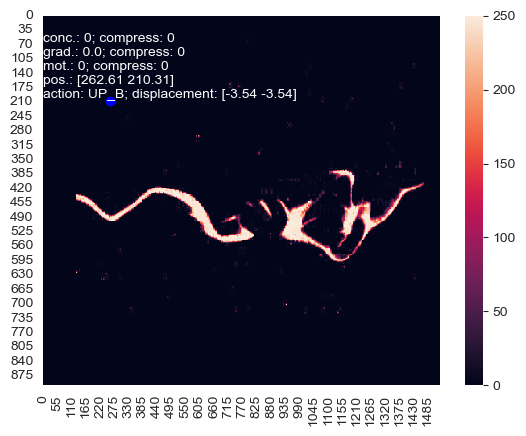

In [3]:
import src.visualization.visualize_behavior

print(save_path)
POLICY_FRAMES_PARENT_DIRECTORY = 'q_policy_stopping_example_frames_23_02_05'

policy_movie_path = os.path.join('..','result_images',POLICY_FRAMES_PARENT_DIRECTORY)
if not os.path.isdir(policy_movie_path):
    os.mkdir(policy_movie_path)

src.visualization.visualize_behavior.main(movie_path=plume_movie_path,q_table_path=save_path,savepath=policy_movie_path)